In [19]:
import math
import json
import csv
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import os
import glob
import datetime
import copy
from random import shuffle
import random

In [20]:
#one bin means no seperation
#two bins means seperation based on up/down
#n bins partitions [-3,3] into n-2 different equal sections with a bin for [-inf,-3] and [3,inf]
#returns an ordered pair representing the bin
def get2DBin(percents, numBins):
    #hardCode 1 bin and 2 bins
    if numBins == 1:
        return (0,0)
    elif numBins == 2:
        return (int(percents[0] >0), int(percents[1]> 0))
    else:
        daily = 0
        weekly = 0
        binWidth = 6/(numBins-2)
        binHeight = 12/(numBins-2)
        for i in range(numBins-1):
            if percents[0] > -3+binWidth*i:
                daily = i+1
            if percents[1] > -6+binHeight*i:
                weekly = i+1
    return daily, weekly

In [36]:
#result is the current stocks change in percent - the ops stock change in percent
def updateElo(currentElo, opsElo, result, flexibility):
    variationFromResult = result-(currentElo-opsElo)
    return currentElo + flexibility*variationFromResult

In [64]:
#returns a dictionary each stock name is the key and value is 2d array row is 1 day, col is 5 day
def createPlayers(directory, stocks, bins):
    stocks_lower = [stock.lower() for stock in stocks]
    consolidated = {}
    if len(stocks) == 0:
        for filename in os.listdir(directory):
            if "csv" in filename:
                consolidated[filename[:-4]] = [[0 for col in range(bins)] for row in range(bins)]
    else:
        for filename in os.listdir(directory):
            if "csv" in filename and filename[:-4].lower() in stocks_lower:
                consolidated[filename[:-4]] = [[0]*bins]*bins
    return consolidated
#createPlayers([],2)

In [65]:
def returns(directory, stock):
    df = pd.read_csv(os.path.join(directory, stock), usecols=["Date", "Adj Close"], parse_dates=True)
    df["daily_returns"] = df["Adj Close"].diff().astype("float64")
    df["daily_returns"] = 100 * df["daily_returns"] / df["Adj Close"].shift(1)
    df["5_day_returns"] = df["daily_returns"].rolling(5).apply(lambda x: 100 * (np.prod(1 + x / 100) - 1), raw=False).astype("float64")
    df["Date"] = df["Date"].astype(str)
    df.dropna(inplace=True)
    df.drop(columns="Adj Close", inplace=True)
    df.columns = [stock[:-4] + "_" + col if col != "Date" else col for col in df.columns]
    return df

In [66]:
#merge all stocks together
directory = "SmallStocks"
files = os.listdir(directory)
master = returns(directory,files[0])

for filename in files[1:]:
    if "csv" in filename:
        master = master.merge(returns(directory,filename), on="Date")
master.head()
master.shape

(2408, 23)

In [76]:
##Now for the main script
#lets see our profits if we bet same amount every single time on the favorite
def binary_unweighted_bet_strat(master,stocks, bins, flexibility):
    players = createPlayers("./SmallStocks",stocks, bins)
    trading_stocks = players.keys()
    #daily profits are the cumulative profits we have each day from all of our trades
    #day profits are profits that we have within each day weighted by how much money we put on
    #since this strat is unweighted for now we will set all the weights to be 1
    daily_profits = [0]
    
    for i in range(master.shape[0]-1):
        players_n = copy.deepcopy(players)
        totalCollisions = 0
        day_profits = []
        
        for stock_1 in trading_stocks:
            numCollisions = 0
            newElo = 0
            bin_1 = get2DBin((master.iloc[i][stock_1+"_daily_returns"],master.iloc[i][stock_1+"_5_day_returns"]), bins)
            a = bin_1[0]
            b = bin_1[1]
            
            for stock_2 in trading_stocks:
                bin_2 = get2DBin((master.iloc[i][stock_2+"_daily_returns"],master.iloc[i][stock_2+"_5_day_returns"]), bins)
                
                
                #the meat of the program happens in here
                if stock_1 != stock_2 and bin_1 == bin_2:
                    expected_result = players[stock_1][a][b]-players[stock_2][a][b]
                    result = master.iloc[i+1][stock_1+"_daily_returns"]-master.iloc[i][stock_2+"_daily_returns"]
                    numCollisions +=1
                    
                    #bet on company 1
                    if expected_result > 0:
                        day_profits.append((result,1))
                    #bet on company 2
                    else:
                        day_profits.append((-result,1))

                    newElo += updateElo(players[stock_1][a][b],
                                        players[stock_2][a][b], result,.01)
                    #print(stock_1)
                    #print(stock_2)
                    #print()
            if numCollisions != 0:
                players_n[stock_1][a][b] = newElo/numCollisions
                totalCollisions += numCollisions
                
                #continue
                #print(stock_1)
                #print(master.iloc[i][stock_1+"_daily_returns"])
                #print(master.iloc[i][stock_1+"_5_day_returns"])
        players = players_n
        #calculate overall profit
        weighted = 0
        total = 0.00001
        for pair in day_profits:
            weighted += pair[0]*pair[1]
            total += pair[1]
        daily_profits.append(daily_profits[-1]+weighted/total)
        #print(players)
        #print(daily_profits)
        #print()
        #return
        #print (i)
    return(daily_profits)
returns5 = binary_unweighted_bet_strat(master, [],5,.01)      

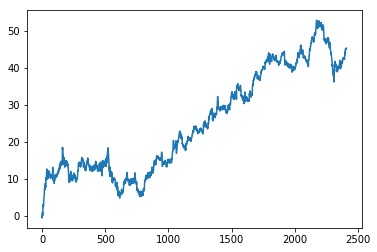

In [77]:
plt.plot(returns)

In [80]:
returns1 = binary_unweighted_bet_strat(master,[],1,.01)

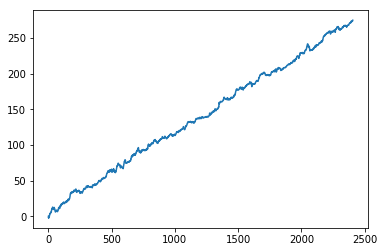

In [81]:
plt.plot(returns1)

In [ ]:
returns2 = binary_unweighted_bet_strat(master,[],2,.01)
returns3 = binary_unweighted_bet_strat(master,[],3,.01)
returns4 = binary_unweighted_bet_